```
 _____   _____   ______  ______   _____    ___    _   __
|  __ \ |  _  |  | ___ \ | ___ \ |  ___|  / _ \  | | / /
| |  \/ | | | |  | |_/ / | |_/ / | |__   / /_\ \ | |/ /
| | __  | | | |  | ___ \ |    /  |  __|  |  _  | |    \
| |_\ \ \ \_/ /  | |_/ / | |\ \  | |___  | | | | | |\  \
 \____/  \___/   \____/  \_| \_| \____/  \_| |_/ \_| \_/
                                                        
                                                        
siRNA Treatment Analysis Tool
```

# ==========================================
# **File Upload Interface for siRNA Analysis Data**
### **Summary:**
### This section introduces an interface for users to upload siRNA analysis input data.

### **Format**:
### The data should be uploaded in ZIP format.

### **Structure of zip file:**
- It should contain folders named 0, 1, 3, and 6, each representing distinct time points.
- Every folder must house a 'montage.tif' file.

### **About montage.tif**
- This file is a composite image with various layers.
- These layers represent the red channel, blue channel, and an RGB merged layer.
- These channels provide insights into RNA progression, RNA intensity, and other related insights at their respective time intervals.

# ==========================================


In [1]:
import os
import shutil
from google.colab import files

# Cleanup old data and files
# ==========================

# Define the directory containing the data
data_dir = '/content/gobreak/data'

# Delete the 'gobreak/data' directory if it exists
if os.path.exists(data_dir):
    shutil.rmtree(data_dir)
    print(f"Cleanup for directory: {data_dir} is complete.")

# Delete any .zip files present in the current directory
for filename in os.listdir('/content'):
    if filename.endswith('.zip'):
        os.remove(os.path.join('/content', filename))

# Upload new data files
# =====================
uploaded = files.upload()


Saving data.zip to data.zip


# ==========================================
# **File Upload and Extraction**
### **Summary:**
### This section focuses on handling uploaded ZIP file in a Colab environment.
#### For each uploaded ZIP file, it:
#### - Saves the uploaded data to a specified directory.
#### - Extracts the contents of the ZIP file to the target directory.

# ==========================================

In [2]:
import os
import zipfile

def extract_zip(zip_file_path, target_dir):
    """Extract the contents of a ZIP file to a specified directory."""
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)
    print(f'Successfully extracted and saved {os.path.basename(zip_file_path)} to {target_dir}.')

def process_uploaded_files(uploaded, target_folder='/content'):
    """Handle uploaded ZIP files: save and extract them to a specified folder."""
    for filename, file_data in uploaded.items():
        if filename.endswith('.zip'):
            zip_file_path = os.path.join(target_folder, filename)

            # Save the uploaded ZIP data
            with open(zip_file_path, 'wb') as f:
                f.write(file_data)

            # Extract the ZIP content
            extract_zip(zip_file_path, target_folder + '/gobreak')

# Process the uploaded files
process_uploaded_files(uploaded)

Successfully extracted and saved data.zip to /content/gobreak.


# ==========================================
# **Input DataSet Validation**
### **Summary:**
### This section focuses on validating the structure of the extracted folders.
### It ensures the presence of expected subdirectories and checks for the existence of 'montage.tif' in each.
# ==========================================

In [3]:
def validate_data_structure(base_directory, required_file='montage.tif'):
    """Validate the structure of the extracted data.

    Parameters:
    - base_directory (str): Path to the base directory.
    - required_file (str): The name of the file that should exist in each subdirectory.

    Returns:
    - list of time sequenced folders containing the montage file
    """
    # Check if folder names are numeric
    present_subdirectories = sorted(os.listdir(base_directory))
    non_numeric_folders = [folder for folder in present_subdirectories if not folder.isnumeric()]

    if non_numeric_folders:
        error_message = f"Error: Unexpected folders {', '.join(non_numeric_folders)}. All folders should have numeric names."
        print(error_message)
        raise ValueError(error_message)

    # Check for 'montage.tif' in each subdirectory
    for subdir in present_subdirectories:
        file_path = os.path.join(base_directory, subdir, required_file)
        if not os.path.isfile(file_path):
            error_message = f"Error: '{required_file}' not found in folder '{subdir}'."
            print(error_message)
            raise ValueError(error_message)

    return present_subdirectories


# Define the directory containing the data
data_dir = 'gobreak/data'

# Validate the structure
montage_folders = validate_data_structure(data_dir)  # This will raise an exception if not valid
print(f"Data is ready for processing!. Montage file found in {montage_folders} folders.")

Data is ready for processing!. Montage file found in ['0', '1', '3', '6'] folders.


# ==================================================================
# **Image Analysis Functions**
### **Summary**:
###        This section contains functions that assist in analyzing
###          various aspects of the images, such as RNA intensity,
###          average intensity for regions, and pink pixel counting.
# ==================================================================

In [4]:
import cv2
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt


## Intensity Analysis for RNA
def get_intensity_of_RNA(rna_region):
    """
    Compute the average intensity of RNA (represented in the red channel) from a region.

    Parameters:
    - rna_region (ndarray): Image region (usually 3-channel) representing an RNA area.

    Returns:
    - float: Average intensity of the red channel for RNA pixels having an intensity greater than 2.
    """
    # Extract the red channel and create a boolean mask of pixels.
    RNA_red_pixels = rna_region[:, :, 2][rna_region[:, :, 2] > 2]
    return np.mean(RNA_red_pixels)


## Intensity Averaging Utility
def get_average_intensity_for_all_region(lst):
    """
    Compute the average of a list of intensities.

    Parameters:
    - lst (list): List of intensity values.

    Returns:
    - float: Average intensity. Returns 0 if the list is empty.
    """
    if len(lst) == 0:
        return 0
    else:
        return sum(lst) / len(lst)


## Pink Pixel tracking
def get_pink_count_from_region(pink_channel):
    """
    Count the number of pink pixels in a given region.

    Parameters:
    - pink_channel (ndarray): Image region to search for pink pixels.

    Returns:
    - int: Count of pink pixels in the region.
    """
    # Define the lower and upper bounds of the pink color range
    lower_pink = np.array([140, 0, 160])
    upper_pink = np.array([255, 100, 255])

    # Create a mask for pixels within the pink color range
    mask = cv2.inRange(pink_channel, lower_pink, upper_pink)

    return np.count_nonzero(mask)


# ==================================================================
# **RNA Data within Nucleus Analysis**
### **Summary**:
###          This section contains a function to extract and analyze
###          RNA data within the nucleus of a cell. It leverages
###          contours to define the nucleus region, then extracts RNA
###          data, pink pixel count, and more from this region.
# ==================================================================

In [5]:
## Function: Extract & Analyze RNA Data within Nucleus
def get_RNA_data_within_nucleus(mask_blue, contour, rna_image, nucleus_image, rgb_pink):
    """
    Extract and analyze RNA data within a specified nucleus region.

    Parameters:
    - mask_blue (ndarray): Binary mask highlighting the nucleus region.
    - contour (array): Contour defining the nucleus boundary.
    - rna_image (ndarray): Image representing RNA data.
    - nucleus_image (ndarray): Image of the nucleus.
    - rgb_pink (ndarray): RGB image highlighting pink regions (possibly overlapping areas).

    Returns:
    - tuple: Extracted RNA region, count of RNA pixels, extracted nucleus channel,
             extracted RNA red channel, average RNA red intensity, and count of pink pixels.
    """
    # Get Extract the corresponding region from the rna image based on nucleus
    mask_contour = np.zeros_like(mask_blue.copy())
    cv2.drawContours(mask_contour, [contour], 0, 255, thickness=cv2.FILLED)

    # Get rna area
    rna_region = cv2.bitwise_and(rna_image, rna_image, mask=mask_contour)
    nucleus_channel = cv2.bitwise_and(nucleus_image, nucleus_image, mask=mask_contour)
    pink_channel = cv2.bitwise_and(rgb_pink, rgb_pink, mask=mask_contour)

    pink_pixel_count = get_pink_count_from_region(pink_channel)

    # Count of available RNA intensity inside region
    RNA_pixels_count = np.count_nonzero(rna_region[:, :, 2] > 2)

    RNA_red_avg = get_intensity_of_RNA(rna_region) if RNA_pixels_count > 0 else 0.0

    return rna_region, RNA_pixels_count, nucleus_channel[:, :, 0], rna_region[:, :, 2], RNA_red_avg, pink_pixel_count


## Function: Calculate Percentage of RNA within Nucleus
def calculate_percentage_of_RNA_within_nucleus(RNA_data_count, nucleus_data_count):
    """
    Calculate the percentage of RNA within a specified nucleus region.

    Parameters:
    - RNA_data_count (int): Count of RNA data pixels within the nucleus region.
    - nucleus_data_count (int): Total pixel count of the nucleus region.

    Returns:
    - float: Percentage of RNA data within the nucleus (capped at 100%).
    """
    percentage_for_nucleus = (RNA_data_count / nucleus_data_count) * 100
    return min(percentage_for_nucleus, 100)


# ====================================================================
# **Nucleus Boundary Analysis**
### **Summary**:
###          This section contains functions to determine and analyze
###          nucleus boundaries, compute RNA presence within these
###          boundaries, and provide a visual representation.
# ====================================================================


In [6]:
# Constants for nucleus detection
LOWER_BLUE = np.array([110, 50, 50])
UPPER_BLUE = np.array([130, 255, 255])

def get_nucleus_mask(image):
    imghsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return cv2.inRange(imghsv, LOWER_BLUE, UPPER_BLUE)

def process_contour(contour, mask, rna_image, nucleus_image, rgb_pink):
    region_rna, RNA_data_count, nucleus_channel, rna_channel, RNA_I_avg, pink_pixel_count = get_RNA_data_within_nucleus(mask, contour, rna_image, nucleus_image, rgb_pink)
    nucleus_data_count = cv2.contourArea(contour)

    # Validity check
    if nucleus_data_count <= 0:
        return None

    x, y, w, h = cv2.boundingRect(contour)
    percentage_for_nucleus = calculate_percentage_of_RNA_within_nucleus(RNA_data_count, nucleus_data_count)
    percentage_of_nucleus_using_pink = calculate_percentage_of_RNA_within_nucleus(pink_pixel_count, nucleus_data_count)
    correlation_coefficient = np.corrcoef(nucleus_channel.flatten(), rna_channel.flatten())[0, 1]

    return {
        "coords": (x, y, w, h),
        "RNA_I_avg": RNA_I_avg,
        "RNA_data_count": RNA_data_count,
        "nucleus_data_count": nucleus_data_count,
        "pink_pixel_count": pink_pixel_count,
        "percentage_for_nucleus": percentage_for_nucleus,
        "percentage_of_nucleus_using_pink": percentage_of_nucleus_using_pink,
        "correlation_coefficient": correlation_coefficient
    }

def find_and_analyze_nucleus_boundaries(nucleus_image, rna_image, rgb_pink):
    mask_blue = get_nucleus_mask(nucleus_image)
    blue_contours, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Total nucleus: {len(blue_contours)}\n\n")

    results = []
    for index, contour in enumerate(blue_contours):
        result = process_contour(contour, mask_blue, rna_image, nucleus_image, rgb_pink)
        if result:
            nucleus_count = index + 1
            print(f"Percentage of siRNA in nucleus {nucleus_count}: {result['percentage_for_nucleus']:.2f}%")
            print(f"Percentage of siRNA in nucleus based on pink color {nucleus_count}: {result['percentage_of_nucleus_using_pink']:.2f}%")
            print(f"Correlation coefficient of nucleus {nucleus_count} & siRNA is : {result['correlation_coefficient']:.4f}")

            results.append(result)

    nucleus_copy = np.copy(nucleus_image)
    for res in results:
        x, y, w, h = res["coords"]
        cv2.rectangle(nucleus_copy, (x, y), (x + w, y + h), (0, 255, 0), 1)
        cv2.putText(nucleus_copy, f"{res['percentage_for_nucleus']:.2f}%", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    overall_progress = calculate_percentage_of_RNA_within_nucleus(sum(res["RNA_data_count"] for res in results), sum(res["nucleus_data_count"] for res in results))
    overall_intensity = np.mean([res["RNA_I_avg"] for res in results])
    overall_progress_with_pink = calculate_percentage_of_RNA_within_nucleus(sum(res["pink_pixel_count"] for res in results), sum(res["nucleus_data_count"] for res in results))

    return nucleus_copy, overall_progress, overall_intensity, overall_progress_with_pink, len(results)


# ==========================================
# **Image Data Analysis Over Time**
### **Summary:**
###          This section processes and analyzes a series of images stored in
###          time sequenced folders to determine RNA interactions within the
###          nucleus.Metrics like progress over time, intensity, and
###          interactions using pink color from the RGB images are collected.
# ==========================================




Processing montage.tif from folder: 0
Total nucleus: 14


Percentage of siRNA in nucleus 1: 1.61%
Percentage of siRNA in nucleus based on pink color 1: 0.00%
Correlation coefficient of nucleus 1 & siRNA is : 0.1046
Percentage of siRNA in nucleus 2: 1.48%
Percentage of siRNA in nucleus based on pink color 2: 0.00%
Correlation coefficient of nucleus 2 & siRNA is : 0.1088
Percentage of siRNA in nucleus 3: 0.74%
Percentage of siRNA in nucleus based on pink color 3: 0.00%
Correlation coefficient of nucleus 3 & siRNA is : 0.0727
Percentage of siRNA in nucleus 4: 1.66%
Percentage of siRNA in nucleus based on pink color 4: 0.00%
Correlation coefficient of nucleus 4 & siRNA is : 0.1273
Percentage of siRNA in nucleus 5: 1.42%
Percentage of siRNA in nucleus based on pink color 5: 0.00%
Correlation coefficient of nucleus 5 & siRNA is : 0.1054
Percentage of siRNA in nucleus 6: 1.73%
Percentage of siRNA in nucleus based on pink color 6: 0.00%
Correlation coefficient of nucleus 6 & siRNA is : 0.111

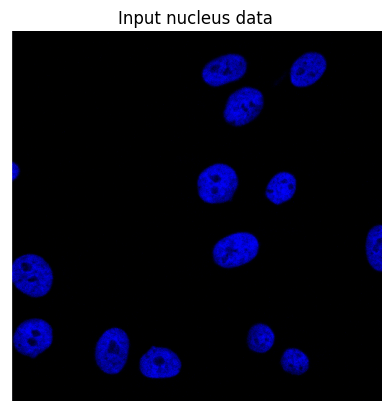

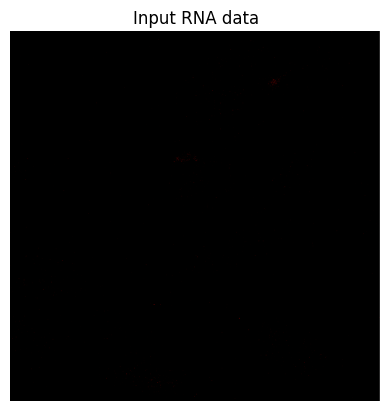

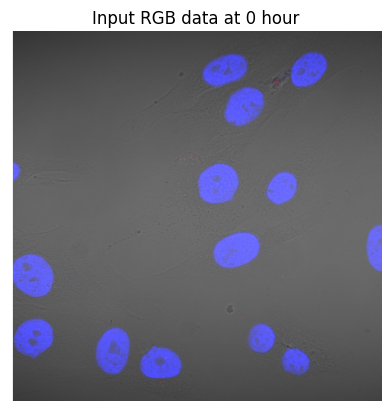

Overall Progress at 0 hour is 2.02 %
Overall Progress with RGB image (pink color) at 0 hour is 0.00 %


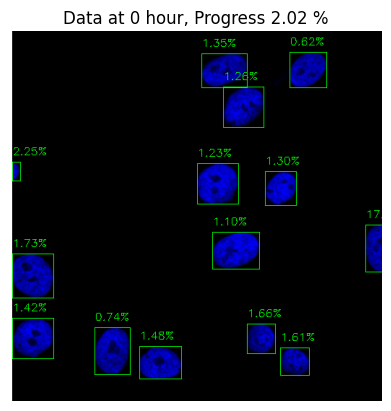



Processing montage.tif from folder: 1
Total nucleus: 12


Percentage of siRNA in nucleus 1: 100.00%
Percentage of siRNA in nucleus based on pink color 1: 5.77%
Correlation coefficient of nucleus 1 & siRNA is : 0.7297
Percentage of siRNA in nucleus 2: 48.88%
Percentage of siRNA in nucleus based on pink color 2: 1.58%
Correlation coefficient of nucleus 2 & siRNA is : 0.5696
Percentage of siRNA in nucleus 3: 64.28%
Percentage of siRNA in nucleus based on pink color 3: 7.90%
Correlation coefficient of nucleus 3 & siRNA is : 0.5563
Percentage of siRNA in nucleus 4: 29.72%
Percentage of siRNA in nucleus based on pink color 4: 0.23%
Correlation coefficient of nucleus 4 & siRNA is : 0.3824
Percentage of siRNA in nucleus 5: 25.49%
Percentage of siRNA in nucleus based on pink color 5: 0.21%
Correlation coefficient of nucleus 5 & siRNA is : 0.3578
Percentage of siRNA in nucleus 6: 18.21%
Percentage of siRNA in nucleus based on pink color 6: 0.04%
Correlation coefficient of nucleus 6 & siRNA is 

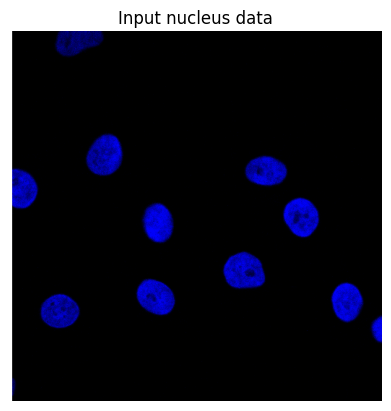

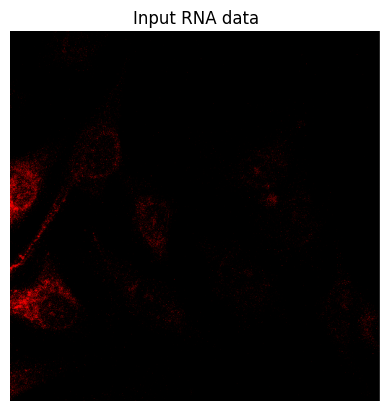

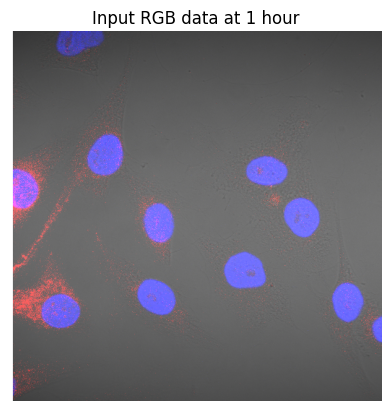

Overall Progress at 1 hour is 42.05 %
Overall Progress with RGB image (pink color) at 1 hour is 1.98 %


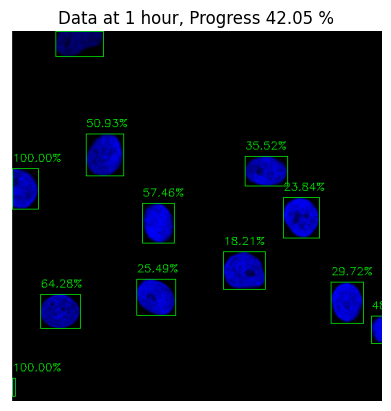



Processing montage.tif from folder: 3
Total nucleus: 18


Percentage of siRNA in nucleus 1: 20.73%
Percentage of siRNA in nucleus based on pink color 1: 0.17%
Correlation coefficient of nucleus 1 & siRNA is : 0.3033
Percentage of siRNA in nucleus 2: 38.61%
Percentage of siRNA in nucleus based on pink color 2: 1.09%
Correlation coefficient of nucleus 2 & siRNA is : 0.4493
Percentage of siRNA in nucleus 3: 33.84%
Percentage of siRNA in nucleus based on pink color 3: 0.83%
Correlation coefficient of nucleus 3 & siRNA is : 0.3999
Percentage of siRNA in nucleus 4: 52.47%
Percentage of siRNA in nucleus based on pink color 4: 2.04%
Correlation coefficient of nucleus 4 & siRNA is : 0.5022
Percentage of siRNA in nucleus 5: 24.93%
Percentage of siRNA in nucleus based on pink color 5: 0.06%
Correlation coefficient of nucleus 5 & siRNA is : 0.3342
Percentage of siRNA in nucleus 6: 30.43%
Percentage of siRNA in nucleus based on pink color 6: 0.00%
Correlation coefficient of nucleus 6 & siRNA is :

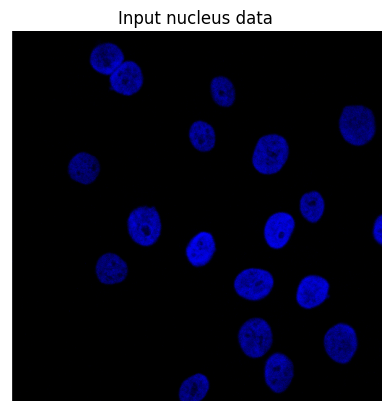

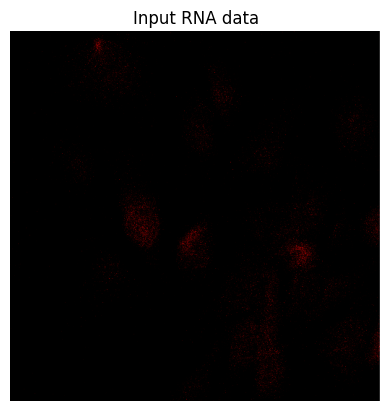

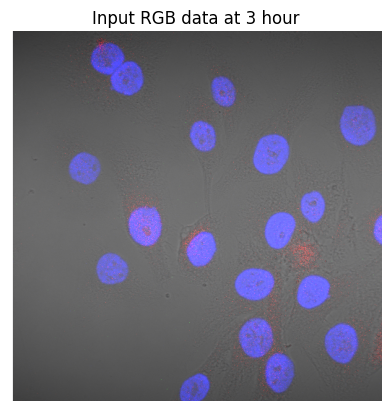

Overall Progress at 3 hour is 36.02 %
Overall Progress with RGB image (pink color) at 3 hour is 0.60 %


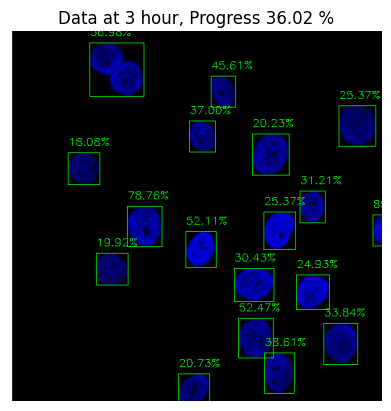



Processing montage.tif from folder: 6
Total nucleus: 15


Percentage of siRNA in nucleus 2: 96.21%
Percentage of siRNA in nucleus based on pink color 2: 45.56%
Correlation coefficient of nucleus 2 & siRNA is : 0.7810
Percentage of siRNA in nucleus 3: 91.50%
Percentage of siRNA in nucleus based on pink color 3: 20.75%
Correlation coefficient of nucleus 3 & siRNA is : 0.7092
Percentage of siRNA in nucleus 4: 79.31%
Percentage of siRNA in nucleus based on pink color 4: 3.45%
Correlation coefficient of nucleus 4 & siRNA is : 0.5574
Percentage of siRNA in nucleus 5: 94.62%
Percentage of siRNA in nucleus based on pink color 5: 17.91%
Correlation coefficient of nucleus 5 & siRNA is : 0.7701
Percentage of siRNA in nucleus 6: 100.00%
Percentage of siRNA in nucleus based on pink color 6: 0.30%
Correlation coefficient of nucleus 6 & siRNA is : 0.8299
Percentage of siRNA in nucleus 7: 95.17%
Percentage of siRNA in nucleus based on pink color 7: 0.26%
Correlation coefficient of nucleus 7 & siRNA 

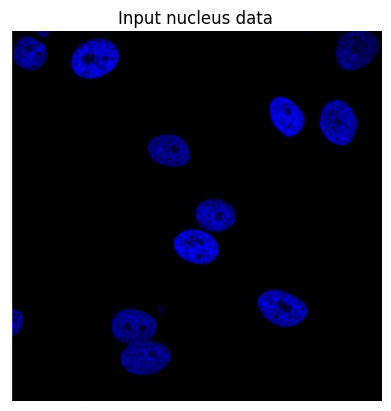

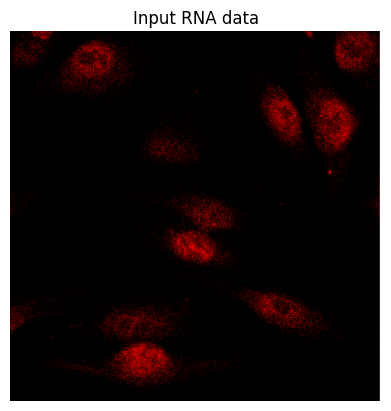

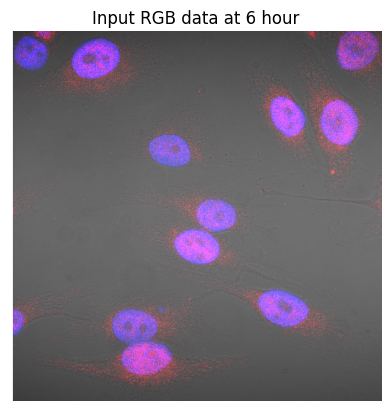

Overall Progress at 6 hour is 95.35 %
Overall Progress with RGB image (pink color) at 6 hour is 27.42 %


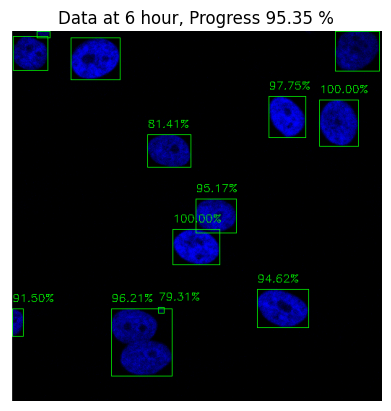

In [7]:
# Constants
NUM_SEGMENTS = 5
MAX_INTENSITY = 255

def split_image_into_segments(image, num_segments=NUM_SEGMENTS):
    """Splits an image into equal segments."""
    width = image.shape[1]
    part_width = width // num_segments
    return [image[:, i * part_width: (i + 1) * part_width] for i in range(num_segments)]

def plot_image(img, title=''):
    """Utility to plot an image."""
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title)
    plt.show()

# Lists to store metrics over time
metrics = {
    'time': [],
    'progress': [],
    'progress_with_pink': [],
    'intensity': [],
    'nucleus_total': []
}

# Process each hour's data and images
for folder_name in montage_folders:
    tiff_file_path = os.path.join(data_dir, folder_name, 'montage.tif')

    if os.path.isfile(tiff_file_path):
        image = tiff.imread(tiff_file_path)
        segments = split_image_into_segments(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        print("\n==============================================================\n")
        print(f"Processing montage.tif from folder: {folder_name}")

        nucleus_boundary_img, overall_progress, overall_intensity, overall_progress_with_pink, nucleus_count = \
            find_and_analyze_nucleus_boundaries(segments[3], segments[0], segments[-1])

        # Plotting
        titles = ['Input nucleus data', 'Input RNA data', f'Input RGB data at {folder_name} hour']
        for idx, img in enumerate([segments[3], segments[0], segments[-1]]):
            plot_image(img, titles[idx])

        overall_intensity_in_percentage = (overall_intensity * 100) / MAX_INTENSITY

        # Appending data to metrics
        metrics['time'].append(folder_name)
        metrics['progress'].append(overall_progress)
        metrics['intensity'].append(overall_intensity_in_percentage)
        metrics['nucleus_total'].append(nucleus_count)
        metrics['progress_with_pink'].append(overall_progress_with_pink)

        print(f"Overall Progress at {folder_name} hour is {overall_progress:.2f} %")
        print(f"Overall Progress with RGB image (pink color) at {folder_name} hour is {overall_progress_with_pink:.2f} %")

        plot_image(nucleus_boundary_img, f'Data at {folder_name} hour, Progress {overall_progress:.2f} %')
    else:
        print(f"TIFF file not found in folder: {folder_name}")


# ==========================================
# **RNA Progression Visualization**
### **Summary:**
###   This section focuses on plotting the RNA progression metrics over time.
###   Multiple lines represent different measures, and the data points are
###   annotated for clarity.
# ==========================================


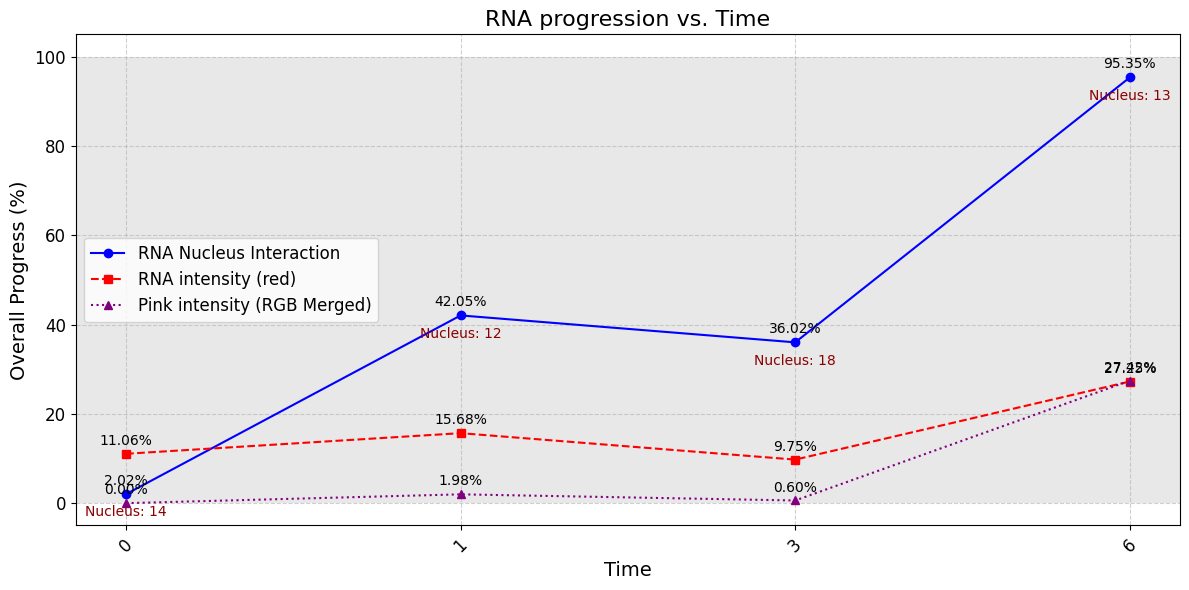

In [8]:
import matplotlib.pyplot as plt

def plot_data(x, y, marker, linestyle, color, label, annotate=True):
    """Function to plot data and annotate the points."""
    plt.plot(x, y, marker=marker, linestyle=linestyle, color=color, label=label)

    if annotate:
        for i, value in enumerate(y):
            plt.annotate(f'{value:.2f}%', (x[i], value + 2), ha='center', fontsize=10)

def visualize_rna_progression(metrics):
    """Function to visualize the RNA progression metrics over time."""
    plt.figure(figsize=(12, 6))

    # Plot Overall Progress vs Time
    plot_data(metrics['time'], metrics['progress'], marker='o', linestyle='-', color='b', label='RNA Nucleus Interaction')

    # Plot RNA Intensity vs Time
    plot_data(metrics['time'], metrics['intensity'], marker='s', linestyle='--', color='r', label='RNA intensity (red)')

    # Plot Overall Progress with Pink vs Time
    plot_data(metrics['time'], metrics['progress_with_pink'], marker='^', linestyle=':', color='purple', label='Pink intensity (RGB Merged)')

    # Annotate the total number of nuclei
    for i, nucleus_count in enumerate(metrics['nucleus_total']):
        plt.annotate(f'Nucleus: {nucleus_count}', (metrics['time'][i], metrics['progress'][i] - 5), ha='center', fontsize=10, color='darkred')

    # Setting various attributes for the plot
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Overall Progress (%)', fontsize=14)
    plt.title('RNA progression vs. Time', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.legend(loc='best', fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.axhspan(0, 100, facecolor='lightgray', alpha=0.5)  # Highlight the region between 0% and 100%
    plt.tight_layout()
    plt.show()

# Invoke the visualization function
visualize_rna_progression(metrics)

# ==========================================
# **Visualization of metrics using grouped bar chart**
# ==========================================


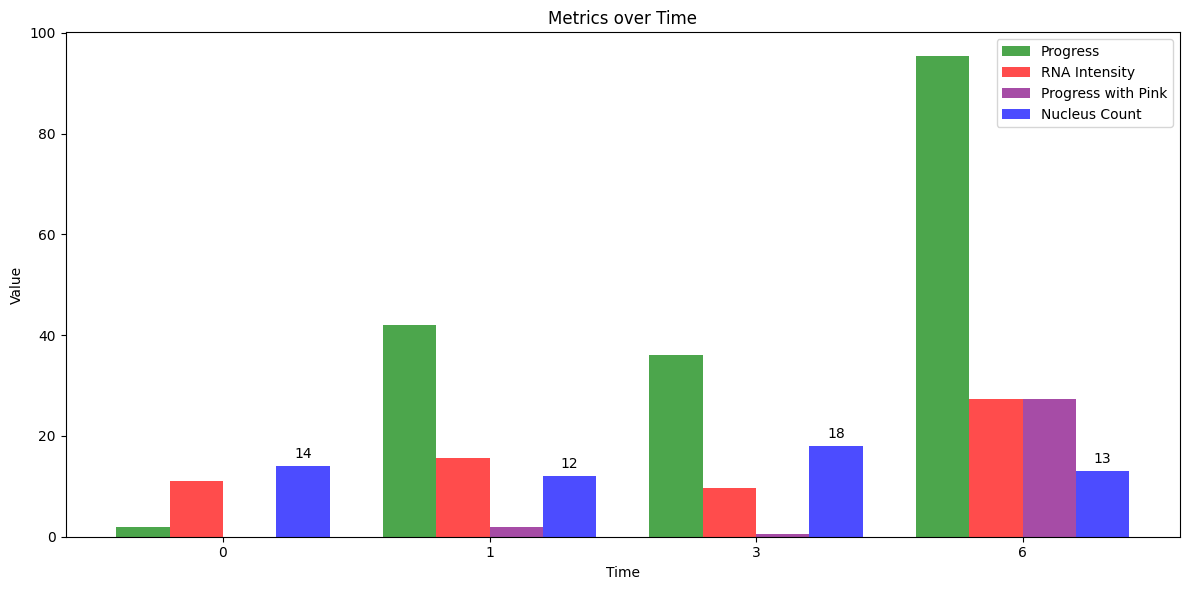

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_bars(positions, data, width, label, color, y_labels=False, fmt='{:.2f}'):
    """Function to plot bars and annotate them."""
    bars = plt.bar(positions, data, width, label=label, color=color, alpha=0.7)

    if y_labels:
        # Label the bars with their heights for clarity
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 1, fmt.format(height), ha='center', va='bottom')

def visualize_metrics_bar_chart(metrics):
    """Function to visualize the metrics using a bar chart."""
    plt.figure(figsize=(12, 6))
    time_points = np.arange(len(metrics['time']))
    bar_width = 0.2

    # Create bars with specified colors
    plot_bars(time_points, metrics['progress'], bar_width, label='Progress', color='green')
    plot_bars(time_points + bar_width, metrics['intensity'], bar_width, label='RNA Intensity', color='red')
    plot_bars(time_points + 2*bar_width, metrics['progress_with_pink'], bar_width, label='Progress with Pink', color='purple')
    plot_bars(time_points + 3*bar_width, metrics['nucleus_total'], bar_width, label='Nucleus Count', color='blue', y_labels=True, fmt='{:.0f}')

    # Plot settings and attributes
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Metrics over Time')
    plt.xticks(time_points + 1.5*bar_width, metrics['time'])
    plt.legend()
    plt.tight_layout()
    plt.show()

# Invoke the visualization function
visualize_metrics_bar_chart(metrics)
